# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 04.12.2021

Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.73099915769926

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [8]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """    
    y_pred = np.full(fill_value=np.nan, shape=(num_runs, X.shape[0]))
    buf_sum = np.zeros(shape=(1, X.shape[0]))[0]
    cnt = np.zeros(X.shape[0])    
    for j in range(num_runs):
        sample = np.random.randint(0, X.shape[0], X.shape[0])
        X_j = X[sample]
        y_j = y[sample]
        a_j = regressor.fit(X_j, y_j)
        oob_sample = list(set(np.arange(X.shape[0])) - set(sample))
        if len(oob_sample) == 0:
            continue
        T_j = X[oob_sample]
        pred = regressor.predict(T_j)
        y_pred[j].flat[oob_sample] = pred 
        buf_sum[oob_sample] += pred
        cnt[oob_sample] += 1  
        
    notzero_msk = (cnt > 1) 
    cnt = cnt[notzero_msk]
    buf_sum = buf_sum.reshape(1, -1)[0][notzero_msk]
    y_oob = y[notzero_msk]
    y_pred = y_pred[:, notzero_msk]
    
    bias = np.mean((buf_sum / cnt - y_oob) ** 2) 
    tmp = ((y_pred - buf_sum/ cnt) ** 2)
    variance = np.mean(np.nansum(tmp, axis=0) / (np.sum(~np.isnan(tmp), axis=0) - 1)) 
    error = np.nanmean((y_pred - y_oob.T) ** 2)        
    return bias, variance, error

часть кода взял здесь: https://github.com/nansy99/machine_learning/blob/cd599ba79f1a22da92a59b14a4b95930ea67e39b/task7/Анастасия%20Дмитриева%20-%20Assignment07.ipynb

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

mod_l = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
str_lst = ['смещение, разброс и ошибка для линейной регрессии:',
         'смещение, разброс и ошибка для решающего дерева:',
         'смещение, разброс и ошибка для случайного леса:']
for i, model in enumerate(mod_l):
    print(str_lst[i], compute_biase_variance(model, X, y))

смещение, разброс и ошибка для линейной регрессии: (23.737500709735052, 0.9397738284614034, 24.654023296412063)
смещение, разброс и ошибка для решающего дерева: (10.38837962871231, 12.985379902747347, 23.41981315552973)
смещение, разброс и ошибка для случайного леса: (10.710724563827146, 2.2827822131369095, 12.998402666777904)


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ ошибка действительно примерно равна сумме смещения и разброса. Для линейной регрессии смешение получилось большим, а разброс маленьким (линейные модели плохо восстанавливают нелинейные зависимости, поэтому сешение большое, а разброс маленький, потому что линейные модели не особо чувствительны к изменению выборки) (согласуется с тем, что обсуждалось на занятиях), для решающего дерева - смешение меньше, чем у линейной регрессии, а разброс больше (поскольку деревья сильно чувствительны к изменениям выборки) (согласуется с теорией), случайный лес является бэггингом над деревьями и в теории должен снижать разброс, не меняя смещения (опять же, согласуется с теорией, хотя смещение чуть-чуть увеличилось)

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

In [10]:
from sklearn.ensemble import BaggingRegressor
lr, dt, rf = LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(n_estimators=40) #если дефолтный 100, то очень долго работает
bag1 = BaggingRegressor(lr, n_estimators=10)
bag2 = BaggingRegressor(dt, n_estimators=10)
bag3 = BaggingRegressor(rf, n_estimators=10)
print('Разброс бэггинга над линейной регрессией:', compute_biase_variance(bag1, X, y)[1])
print('Разброс бэггинга над решающим деревом:', compute_biase_variance(bag2, X, y)[1])
print('Разброс бэггинга над случайным лесом:', compute_biase_variance(bag3, X, y)[1])

Разброс бэггинга над линейной регрессией: 0.9840737604927614
Разброс бэггинга над решающим деревом: 3.418168565267051
Разброс бэггинга над случайным лесом: 1.4064078899162185


__Your answer here:__ бэггинг может снижать разброс в N (число базовых алгоритмов) раз, при условии, что ковариация (2-е слагаемое, когда расписываем разброс), равно нулю. В нашем случае N=10. Видим, что в нашем случае разброс не уменьшается в 10 раз, видимо, из-за скоррелированности базовых алгоритмов. В случае линейной регрессии разброс был и так довольно мал, для дерева удалось уменьшить на 9.5, для леса на 0.8. 

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [11]:
from sklearn.model_selection import train_test_split
def plot_predictions(regressor, X, y, ax, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects, random_state=42)
    for j in range(num_runs):
        sample = np.random.randint(0, X_train.shape[0], X_train.shape[0])
        X_j = X_train[sample]
        y_j = y_train[sample]
        a_j = regressor.fit(X_j, y_j)
        pred = regressor.predict(X_test)
        ax.scatter(x=np.arange(num_test_objects), y=pred, c='lightgreen')
        ax.scatter(x=np.arange(num_test_objects), y=y_test, c='black')
        ax.set_xlabel('test_object', fontsize=12)
        ax.set_ylabel('prediction', fontsize=12)
        ax.set_title(title, fontsize=14)
    ax.legend(['predicted', 'true'], loc='upper right')

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

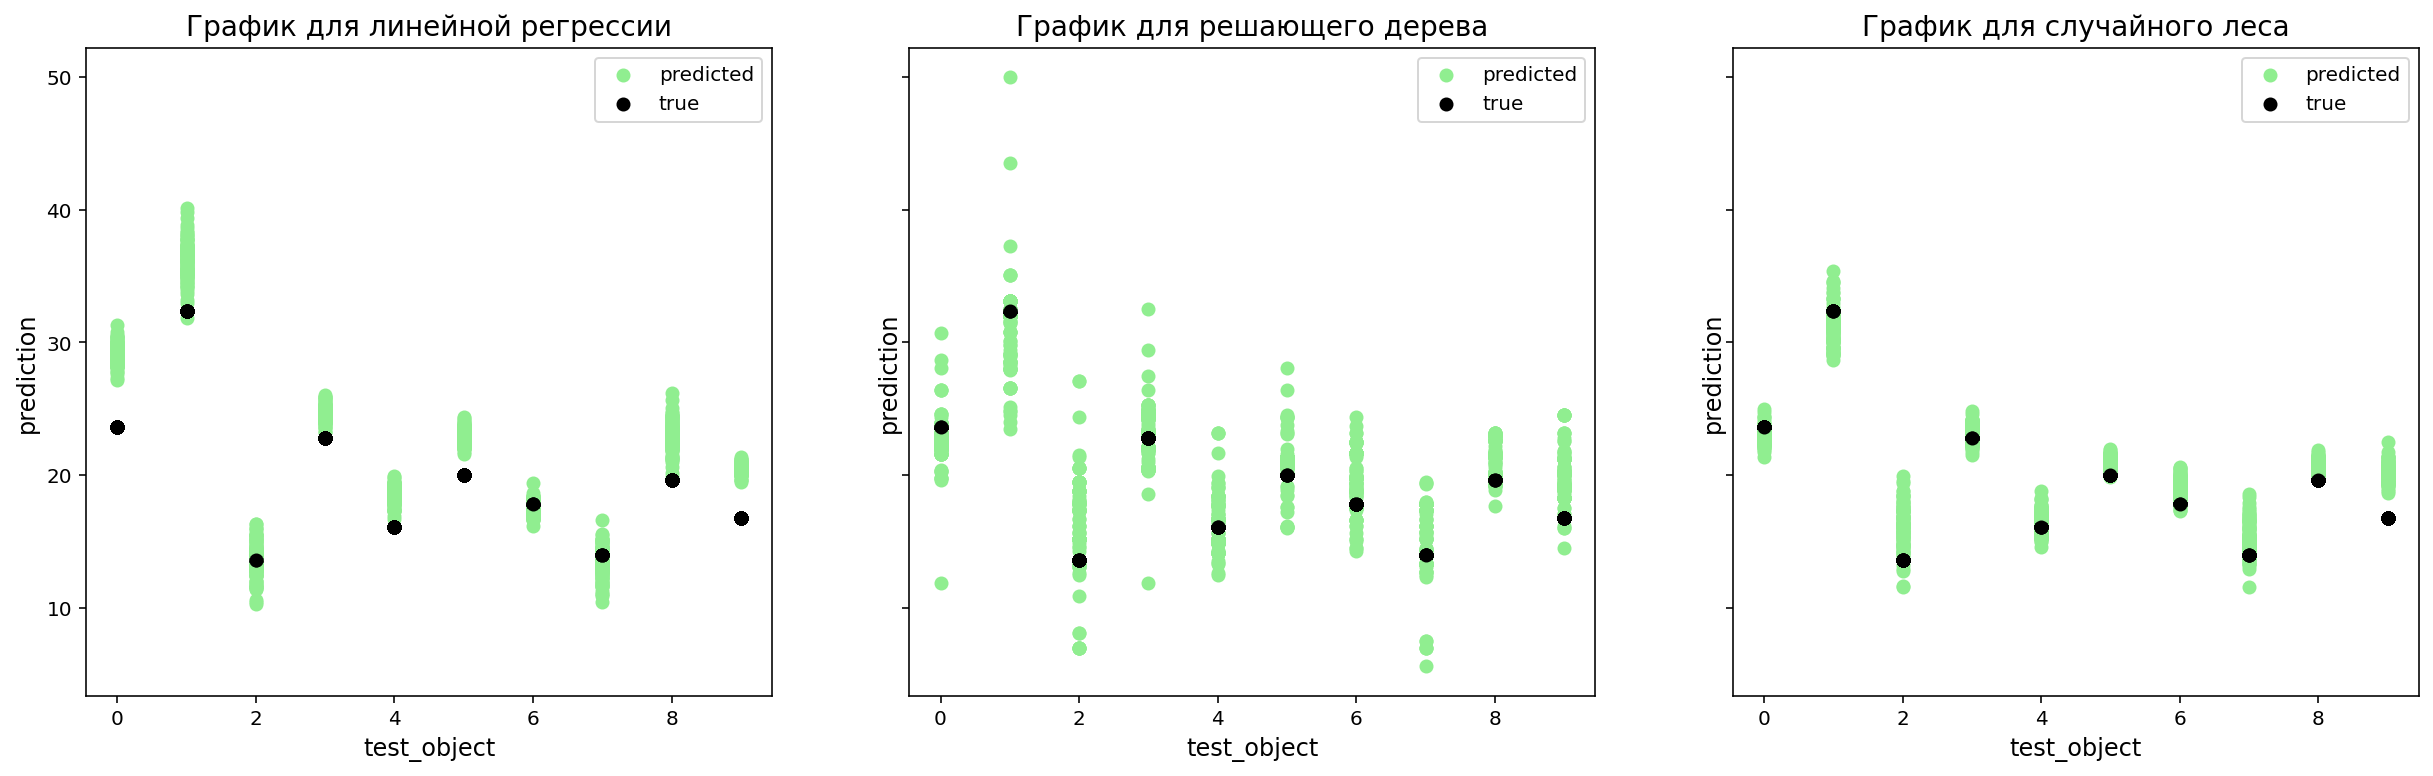

In [12]:
%config InlineBackend.figure_format = 'retina'
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey='row')
title_lst = ['График для линейной регрессии',
             'График для решающего дерева',
             'График для случайного леса']
for i, model in enumerate(mod_l):
    plot_predictions(model, X, y, axs[i], num_runs=100, num_test_objects=10, title=title_lst[i])
fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.95,
                    hspace=0.25, wspace=0.2)

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ 1) Для линейной регрессии часто истинные значения отстают от прогнозов, но "кучность" очень хорошая, т.к. предсказания довольно сильно сконцентрированны и близки друг к другу, то есть имеется довольно высокое смещение (видно, что регрессия далека от того, чтобы восстановить истинную зависимость), а разброс небольшой. 2) Для деревьев, ожидаемо, ситуация другая: истинные значения покрываются напрогнозированными точками, но прогнозы сильно раскиданы, то есть можно говорить о том, что смещение ниже, чем у линейной модели, а разброс выше. 3) Лес должен за счет бэггинга снижать разброс, не особенно меняя смещения, так и происходит: прогнозы гораздо ближе друг к другу в сравнении с деревом, при этом "точность" прогнозрования более-менее одинаковая.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

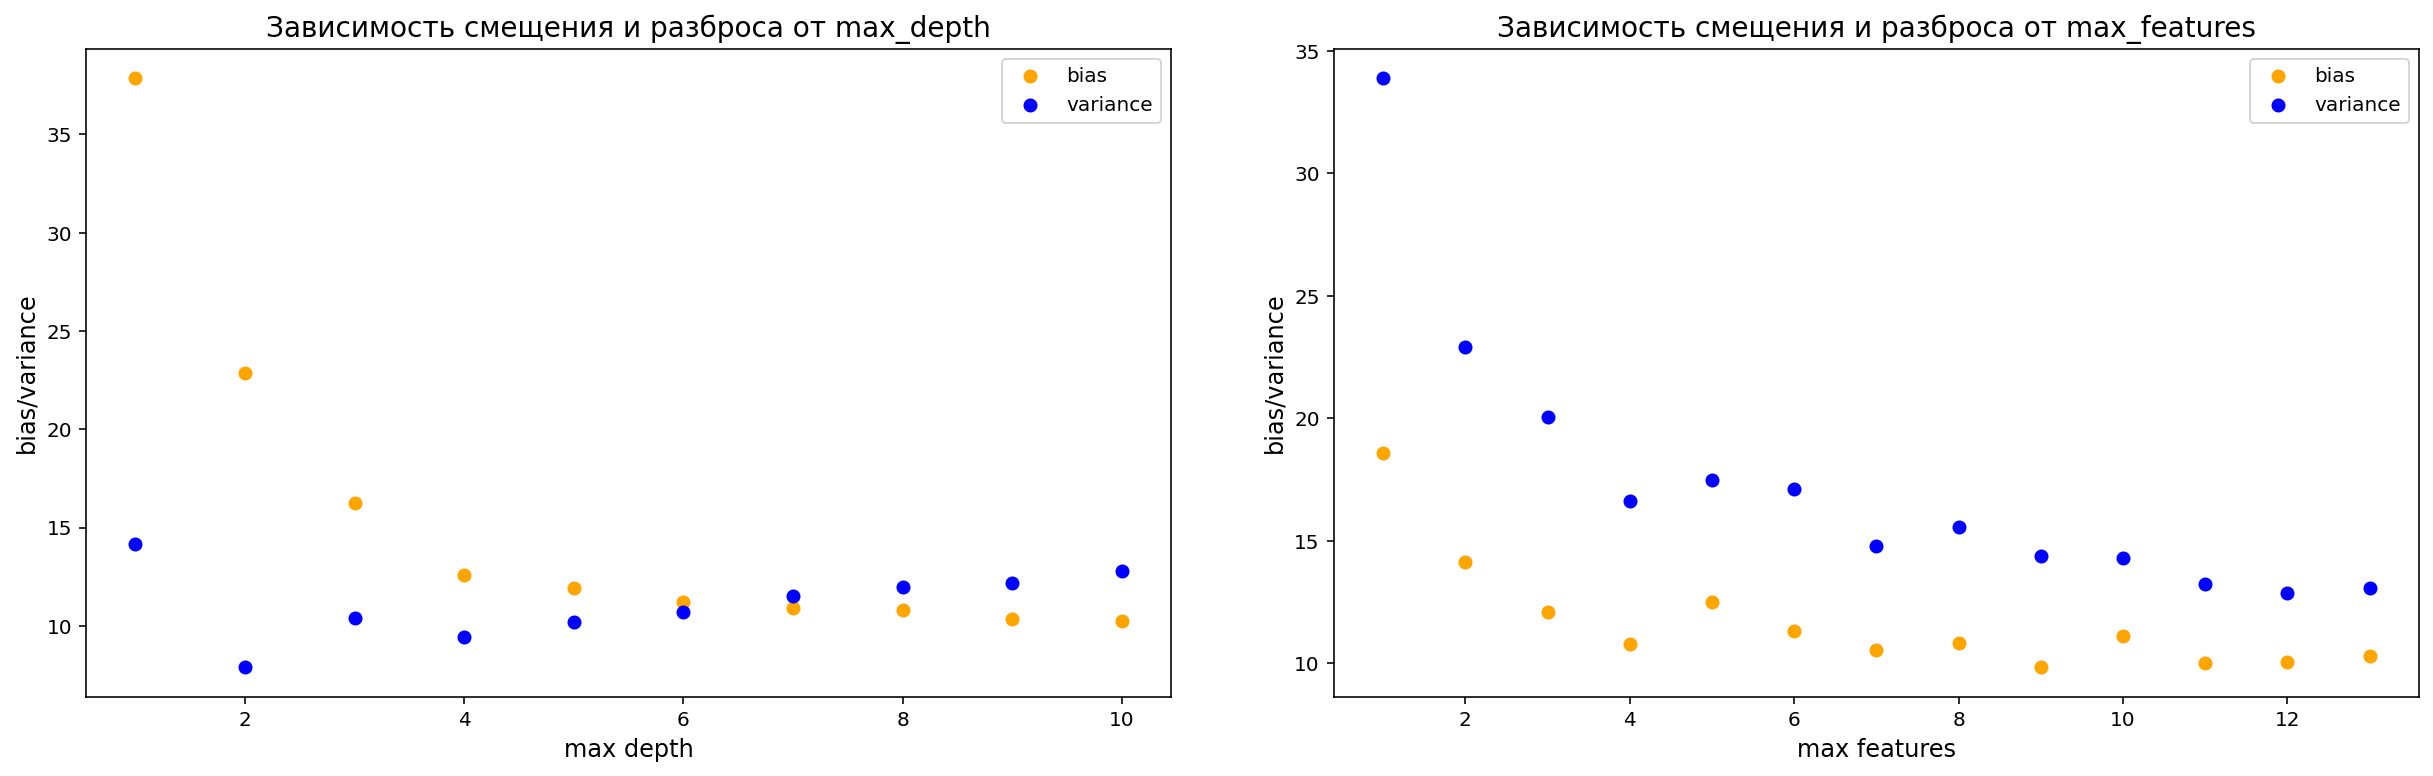

In [13]:
max_d_lst = list(np.arange(1, 11))
max_f_lst = list(np.arange(1, X.shape[1] + 1))
bias_lst1 = []
variance_lst1 = []
bias_lst2 = []
variance_lst2 = []
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
for md in max_d_lst:
    dt = DecisionTreeRegressor(max_depth=md, random_state=42)
    bias, variance, error = compute_biase_variance(dt, X, y, num_runs=1000)
    bias_lst1.append(bias)
    variance_lst1.append(variance)
    
for mf in max_f_lst:
    dt = DecisionTreeRegressor(max_features=mf, random_state=42)
    bias, variance, error = compute_biase_variance(dt, X, y, num_runs=1000)
    bias_lst2.append(bias)
    variance_lst2.append(variance)
    
axs[0].scatter(x=max_d_lst, y=bias_lst1, c='orange')
axs[0].scatter(x=max_d_lst, y=variance_lst1, c='blue')
axs[0].set_xlabel('max depth', fontsize=12)
axs[0].set_ylabel('bias/variance', fontsize=12)
axs[0].set_title('Зависимость смещения и разброса от max_depth', fontsize=14)
axs[0].legend(['bias', 'variance'], loc='upper right')

axs[1].scatter(x=max_f_lst, y=bias_lst2, c='orange')
axs[1].scatter(x=max_f_lst, y=variance_lst2, c='blue')
axs[1].set_xlabel('max features', fontsize=12)
axs[1].set_ylabel('bias/variance', fontsize=12)
axs[1].set_title('Зависимость смещения и разброса от max_features', fontsize=14)
axs[1].legend(['bias', 'variance'], loc='upper right')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.95,
                    hspace=0.25, wspace=0.15)

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

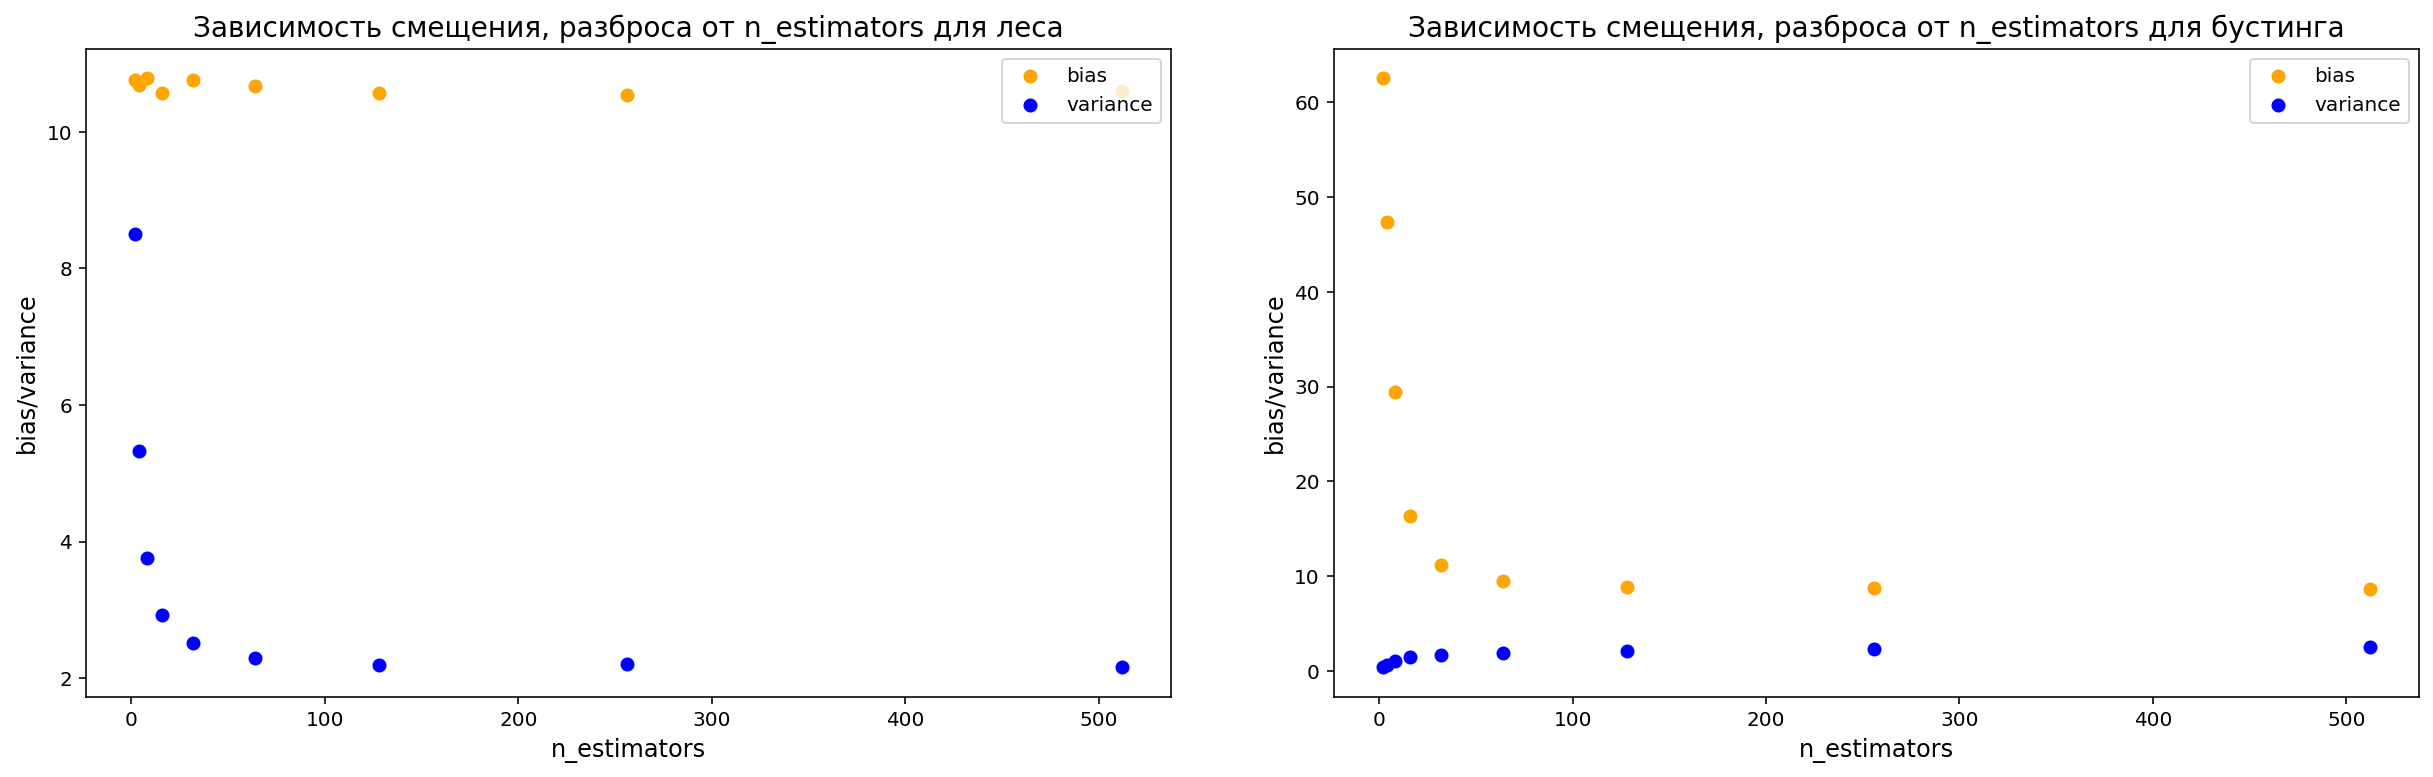

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
n_estimators_lst = list(2**np.arange(1, 10))
bias_lst1 = []
variance_lst1 = []
bias_lst2 = []
variance_lst2 = []
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
for ne in n_estimators_lst:
    rf = RandomForestRegressor(n_estimators=ne)
    bias, variance, error = compute_biase_variance(rf, X, y, num_runs=1000)
    bias_lst1.append(bias)
    variance_lst1.append(variance)
    
    gb = GradientBoostingRegressor(n_estimators=ne)
    bias, variance, error = compute_biase_variance(gb, X, y, num_runs=1000)
    bias_lst2.append(bias)
    variance_lst2.append(variance)
    
axs[0].scatter(x=n_estimators_lst, y=bias_lst1, c='orange')
axs[0].scatter(x=n_estimators_lst, y=variance_lst1, c='blue')
axs[0].set_xlabel('n_estimators', fontsize=12)
axs[0].set_ylabel('bias/variance', fontsize=12)
axs[0].set_title('Зависимость смещения, разброса от n_estimators для леса', fontsize=14)
axs[0].legend(['bias', 'variance'], loc='upper right')

axs[1].scatter(x=n_estimators_lst, y=bias_lst2, c='orange')
axs[1].scatter(x=n_estimators_lst, y=variance_lst2, c='blue')
axs[1].set_xlabel('n_estimators', fontsize=12)
axs[1].set_ylabel('bias/variance', fontsize=12)
axs[1].set_title('Зависимость смещения, разброса от n_estimators для бустинга', fontsize=14)
axs[1].legend(['bias', 'variance'], loc='upper right')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.95,
                    hspace=0.25, wspace=0.15)

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__ 1) по 1-му графику можно сказать, что все соответствует тому, что было сказано на лекции: с ростом глубины для деревьев смещение должно уменьшаться, а разброс расти  
2) для 2-го графика можно сказать, что, как можно было предположить, с ростом числа признаков (особенно с добавлением полезных признаков) алгоритм должен иметь возможность лучше приблизиться к идеальному, соответственно, смещение должно снижаться, а разброс должен снижаться за счет того, что чем меньше признаков есть, из которых дерево может выбирать, тем более вероятно, что  деревья получатся разные и мы будем получать на разных выборках очень различные ошибки (как большие, так и маленькие)  
3) как и обсуждалось на занятиях, с ростом числа базовых алгоритмов (деревьев) ошибка на тесте для леса должна падать, соответственно, мы должны сильнее приближаться к идеальному алгоритму, а значит смещение должно падать, но, видимо, лес изначально имеет довольно небольшое смещение (равное примерно 10), которое крайне тяжело снизить, судя по тому, что это же значение является минимальным смещением для бустинга (см. 4 график). Вместе с тем падает и разброс, видимо, потому, что чем больше базовых алгоритмов мы берем, тем менее чувствительным является наш итоговый ансамбль к какому-то изменению выборки  
4) смещение уменьшается с ростом числа базовых алгоритмов (как и должно быть в случае бустинга), а разброс слегка растет, но потом практически постоянный. Константность разброса не совсем понятна, возможно, это связано как-то со значением learning-rate по умолчанию, и у нас не достаточно много базовых алгоритмов, чтобы разброс, возможно, вырос сильнее.

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

<img src="https://c.tenor.com/upPmgF2cbWQAAAAd/american-psycho-joker.gif" style="width: 200px">